In [1]:
# Mount Google Drive
from google.colab import drive
import os

drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!pip install labelme2coco
import labelme2coco
from labelme2coco import convert

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 87.2/87.2 kB 7.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 111.3/111.3 kB 10.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.2/62.2 MB 9.4 MB/s eta 0:00:00
  Created wheel for fire: filename=fire-0.7.0-py3-none-any.whl size=114249 sha256=75218984046bb53e30e557d38ba12c93a9d07b2760ad772abd84e2c3f368ccbd
  Stored in directory: /root/.cache/pip/wheels/19/39/2f/2d3cadc408a8804103f1c34ddd4b9f6a93497b11fa96fe738e
Successfully built fire
  Attempting uninstall: opencv-python
    Found existing installation: opencv-python 4.10.0.84
    Uninstalling opencv-python-4.10.0.84:
      Successfully uninstalled opencv-python-4.10.0.84


In [3]:
input_dir = "/content/drive/MyDrive/AI_ML_Project/jsons" # where the annotated json files are stored
output_file = "/content/drive/MyDrive/AI_ML_Project/coco_annotations.json" # where the final json file will be stored (will be called dataset.json)
convert(input_dir, output_file)

There are 93 listed files in folder jsons.


Converting labelme annotations to COCO format: 100%|██████████| 93/93 [00:35<00:00,  2.59it/s]


In [2]:
!pip install ultralytics
from ultralytics import YOLO

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 896.9/896.9 kB 21.3 MB/s eta 0:00:00
Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


In [9]:
import cv2
import json
import os

def convert_yolact_to_yolo(yolact_json, image_dir, output_dir, class_mapping):
    with open(yolact_json, 'r') as f:
        data = json.load(f)

    if not os.path.exists(output_dir):
        os.makedirs(output_dir)

    for image in data['images']:
        image_id = image['id']
        image_name = os.path.basename(image['file_name'])
        image_width = image['width']
        image_height = image['height']

        annotations = [
            ann for ann in data['annotations'] if ann['image_id'] == image_id
        ]

        # change this to fit the classes that you have, check the converted file, probably will be the same
        class_mapping = {
            't': 0,  # tongue (example)
            'o': 1,  # blue circle (example)
            'n': 2   # color card (example)
            }

        label_file = os.path.join(output_dir, f"{os.path.splitext(image_name)[0]}.txt")
        with open(label_file, 'w') as f_out:
            for ann in annotations:
                category_id = ann['category_id']
                bbox = ann['bbox']  # x_min, y_min, width, height

                # Convert to YOLO format
                x_center = (bbox[0] + bbox[2] / 2) / image_width
                y_center = (bbox[1] + bbox[3] / 2) / image_height
                width = bbox[2] / image_width
                height = bbox[3] / image_height

                class_id = category_id  # Map to YOLO class ID
                f_out.write(f"{class_id} {x_center} {y_center} {width} {height}\n")

image_dir = '/content/drive/MyDrive/AI_ML_Project/train/images'
output_dir = '/content/drive/MyDrive/AI_ML_Project/train/labels'
convert_yolact_to_yolo('/content/drive/MyDrive/AI_ML_Project/dataset/dataset.json', image_dir, output_dir, 'tongue')

In [2]:
image_dir2 = '/content/drive/MyDrive/AI_ML_Project/val/images'
output_dir2 = '/content/drive/MyDrive/AI_ML_Project/val/labels'
convert_yolact_to_yolo('/content/drive/MyDrive/AI_ML_Project/dataset/dataset.json', image_dir2, output_dir2, 'tongue')

NameError: name 'convert_yolact_to_yolo' is not defined

In [4]:
# Specify the YAML content (change the names to what you annotated with)
yaml_content = """
train: /content/drive/MyDrive/AI_ML_Project/train/images
val: /content/drive/MyDrive/AI_ML_Project/val/images

nc: 3
names: ['tongue', 'colorcard', 'blue']
"""

# Create and write to the YAML file
with open('/content/dataset.yaml', 'w') as file:
    file.write(yaml_content)

print("YAML file created successfully!")

YAML file created successfully!


In [5]:
print(yaml_content)


train: /content/drive/MyDrive/AI_ML_Project/train/images
val: /content/drive/MyDrive/AI_ML_Project/val/images

nc: 3
names: ['tongue', 'colorcard', 'blue']



In [6]:
model = YOLO('yolov8n.pt')
model.train(data='/content/dataset.yaml', epochs=75, imgsz=1024)

100%|██████████| 6.25M/6.25M [00:00<00:00, 326MB/s]

Ultralytics 8.3.39 🚀 Python-3.10.12 torch-2.5.1+cu121 CUDA:0 (Tesla T4, 15102MiB)


engine/trainer: task=detect, mode=train, model=yolov8n.pt, data=/content/dataset.yaml, epochs=75, time=None, patience=100, batch=16, imgsz=1024, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=train, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True, show_conf=True, show_boxes=True, line_width=None, format=torchscript, keras=False, optimize=False, int8=False, d

100%|██████████| 755k/755k [00:00<00:00, 103MB/s]


Overriding model.yaml nc=80 with nc=3

                   from  n    params  module                                       arguments                     
  0                  -1  1       464  ultralytics.nn.modules.conv.Conv             [3, 16, 3, 2]                 
  1                  -1  1      4672  ultralytics.nn.modules.conv.Conv             [16, 32, 3, 2]                
  2                  -1  1      7360  ultralytics.nn.modules.block.C2f             [32, 32, 1, True]             
  3                  -1  1     18560  ultralytics.nn.modules.conv.Conv             [32, 64, 3, 2]                
  4                  -1  2     49664  ultralytics.nn.modules.block.C2f             [64, 64, 2, True]             
  5                  -1  1     73984  ultralytics.nn.modules.conv.Conv             [64, 128, 3, 2]               
  6                  -1  2    197632  ultralytics.nn.modules.block.C2f             [128, 128, 2, True]           
  7                  -1  1    295424  ultralytics

100%|██████████| 5.35M/5.35M [00:00<00:00, 201MB/s]


AMP: checks passed ✅


train: Scanning /content/drive/MyDrive/AI_ML_Project/train/labels.cache... 79 images, 0 backgrounds, 0 corrupt: 100%|██████████| 79/79 [00:00<?, ?it/s]


albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))


/usr/local/lib/python3.10/dist-packages/albumentations/__init__.py:24: UserWarning: A new version of Albumentations is available: 1.4.21 (you have 1.4.20). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()
val: Scanning /content/drive/MyDrive/AI_ML_Project/val/labels.cache... 14 images, 0 backgrounds, 0 corrupt: 100%|██████████| 14/14 [00:00<?, ?it/s]


Plotting labels to runs/detect/train/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.001429, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 1024 train, 1024 val
Using 2 dataloader workers
Logging results to runs/detect/train
Starting training for 75 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/75      5.29G      1.565      3.743      1.845         75       1024: 100%|██████████| 5/5 [00:28<00:00,  5.64s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:02<00:00,  2.37s/it]

                   all         14         42     0.0049        0.5     0.0379     0.0101



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/75      5.25G      1.238      3.395      1.573         90       1024: 100%|██████████| 5/5 [00:03<00:00,  1.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:02<00:00,  2.54s/it]

                   all         14         42    0.00665      0.667      0.428      0.318



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/75      5.23G     0.8774      2.312      1.266         80       1024: 100%|██████████| 5/5 [00:01<00:00,  2.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.30it/s]

                   all         14         42    0.00885      0.667      0.659      0.505



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/75      5.24G     0.8094      1.741      1.226         82       1024: 100%|██████████| 5/5 [00:01<00:00,  2.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.01it/s]

                   all         14         42     0.0169      0.667       0.65      0.522



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/75      5.25G     0.7924      1.473      1.179         76       1024: 100%|██████████| 5/5 [00:01<00:00,  2.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.77it/s]

                   all         14         42     0.0407      0.667      0.654      0.536



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/75      5.25G     0.7721      1.394      1.172         72       1024: 100%|██████████| 5/5 [00:02<00:00,  2.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.58it/s]

                   all         14         42      0.808      0.667      0.662      0.559



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/75      5.25G     0.7353      1.278      1.134         82       1024: 100%|██████████| 5/5 [00:01<00:00,  2.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.41it/s]

                   all         14         42      0.981      0.434      0.664      0.552



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/75      5.25G     0.7194       1.24      1.141         78       1024: 100%|██████████| 5/5 [00:01<00:00,  2.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.71it/s]

                   all         14         42      0.968      0.646      0.664      0.546



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/75      5.25G     0.7281      1.185      1.116         81       1024: 100%|██████████| 5/5 [00:01<00:00,  2.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.02it/s]

                   all         14         42      0.983      0.665      0.666       0.54



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/75      5.24G     0.7777      1.142      1.145         76       1024: 100%|██████████| 5/5 [00:02<00:00,  2.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.26it/s]

                   all         14         42      0.878      0.625      0.663      0.527



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/75      5.25G     0.7413        1.1      1.094         93       1024: 100%|██████████| 5/5 [00:01<00:00,  2.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.27it/s]

                   all         14         42      0.851      0.544       0.69       0.58



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/75      5.24G     0.7268      1.087      1.118         65       1024: 100%|██████████| 5/5 [00:01<00:00,  2.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.05it/s]

                   all         14         42      0.886       0.59      0.664      0.567



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/75       5.2G     0.7081      1.015      1.095         80       1024: 100%|██████████| 5/5 [00:01<00:00,  2.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.67it/s]

                   all         14         42       0.92      0.518      0.894      0.746



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/75      5.25G     0.7427      1.031      1.126         87       1024: 100%|██████████| 5/5 [00:02<00:00,  2.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.86it/s]

                   all         14         42      0.954      0.537      0.901      0.764



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/75      5.25G     0.7007      1.026      1.075         94       1024: 100%|██████████| 5/5 [00:02<00:00,  1.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.47it/s]

                   all         14         42      0.968       0.63      0.995      0.821



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/75      5.25G      0.727     0.9654       1.09         85       1024: 100%|██████████| 5/5 [00:01<00:00,  2.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.76it/s]

                   all         14         42      0.879      0.698      0.976        0.8



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/75      5.23G     0.6926     0.9616      1.088         77       1024: 100%|██████████| 5/5 [00:01<00:00,  2.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.07it/s]

                   all         14         42      0.858      0.758      0.959      0.745



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/75      5.23G     0.7296     0.9824       1.12         68       1024: 100%|██████████| 5/5 [00:01<00:00,  2.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.00it/s]

                   all         14         42      0.907      0.909      0.986      0.777



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/75      5.25G     0.7139     0.9728      1.095         81       1024: 100%|██████████| 5/5 [00:02<00:00,  1.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.83it/s]

                   all         14         42      0.894      0.901      0.995      0.787



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/75      5.23G     0.6647     0.9195      1.089         73       1024: 100%|██████████| 5/5 [00:01<00:00,  2.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.13it/s]

                   all         14         42       0.89      0.958      0.995      0.829



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      21/75      5.24G     0.7158     0.9654      1.145        106       1024: 100%|██████████| 5/5 [00:01<00:00,  2.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.13it/s]

                   all         14         42      0.904      0.962      0.987      0.835



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      22/75      5.25G     0.7069     0.8904      1.087         82       1024: 100%|██████████| 5/5 [00:01<00:00,  2.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.96it/s]

                   all         14         42      0.921      0.986      0.992      0.822



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      23/75      5.25G     0.7262     0.8831       1.12         66       1024: 100%|██████████| 5/5 [00:02<00:00,  2.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.89it/s]

                   all         14         42      0.961      0.979      0.989      0.788



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      24/75      5.24G     0.6916     0.9212      1.142         78       1024: 100%|██████████| 5/5 [00:01<00:00,  2.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.13it/s]

                   all         14         42      0.986      0.979      0.995      0.806



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      25/75      5.24G     0.7041     0.8547      1.066         73       1024: 100%|██████████| 5/5 [00:01<00:00,  2.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.22it/s]

                   all         14         42      0.982       0.99      0.995      0.805



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      26/75      5.25G     0.6792     0.8447      1.083         78       1024: 100%|██████████| 5/5 [00:01<00:00,  2.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.60it/s]

                   all         14         42      0.972      0.998      0.995      0.822



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      27/75      5.26G     0.6611     0.7941       1.05         81       1024: 100%|██████████| 5/5 [00:02<00:00,  2.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.73it/s]

                   all         14         42      0.979      0.998      0.995      0.804



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      28/75      5.25G     0.6716     0.8286      1.074         71       1024: 100%|██████████| 5/5 [00:02<00:00,  1.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.77it/s]

                   all         14         42       0.97       0.98      0.995      0.802



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      29/75      5.25G     0.6504     0.8119      1.056         85       1024: 100%|██████████| 5/5 [00:01<00:00,  2.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.37it/s]

                   all         14         42      0.966      0.991      0.995      0.801



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      30/75      5.23G     0.6457     0.7945       1.05         96       1024: 100%|██████████| 5/5 [00:01<00:00,  2.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.36it/s]

                   all         14         42      0.957      0.995      0.995      0.792



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      31/75      5.19G     0.6622     0.8821      1.083         66       1024: 100%|██████████| 5/5 [00:01<00:00,  2.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.04it/s]

                   all         14         42      0.997      0.995      0.995      0.795



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      32/75      5.26G      0.661     0.8195      1.073         78       1024: 100%|██████████| 5/5 [00:02<00:00,  1.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.99it/s]

                   all         14         42      0.993      0.986      0.995      0.811



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      33/75       5.2G     0.6141     0.7849      1.021         69       1024: 100%|██████████| 5/5 [00:01<00:00,  2.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.33it/s]

                   all         14         42      0.992      0.982      0.995      0.813



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      34/75      5.25G     0.6328     0.7161      1.031         98       1024: 100%|██████████| 5/5 [00:01<00:00,  2.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.74it/s]

                   all         14         42      0.989      0.982      0.995      0.797



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      35/75      5.25G     0.5935     0.6943     0.9882         83       1024: 100%|██████████| 5/5 [00:01<00:00,  2.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.11it/s]

                   all         14         42      0.993      0.979      0.995      0.802



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      36/75      5.25G     0.5884     0.6915      1.009         77       1024: 100%|██████████| 5/5 [00:02<00:00,  2.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.85it/s]

                   all         14         42      0.959      0.992      0.995      0.826



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      37/75      5.25G      0.588     0.7013      1.023         93       1024: 100%|██████████| 5/5 [00:01<00:00,  2.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.28it/s]

                   all         14         42       0.96      0.986      0.995      0.801



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      38/75      5.25G     0.5999     0.7073      1.042         84       1024: 100%|██████████| 5/5 [00:01<00:00,  2.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.18it/s]

                   all         14         42      0.958      0.996      0.995      0.822



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      39/75      5.26G     0.6096     0.7238      1.049         68       1024: 100%|██████████| 5/5 [00:01<00:00,  2.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.40it/s]

                   all         14         42      0.968      0.989      0.995      0.825



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      40/75      5.26G     0.5806     0.6699     0.9962         72       1024: 100%|██████████| 5/5 [00:02<00:00,  2.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.68it/s]

                   all         14         42      0.986      0.979      0.995      0.828



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      41/75      5.25G     0.5977     0.6913      1.041         63       1024: 100%|██████████| 5/5 [00:02<00:00,  1.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.63it/s]

                   all         14         42      0.969      0.997      0.995      0.817



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      42/75      5.25G     0.5967     0.6713      1.027         75       1024: 100%|██████████| 5/5 [00:01<00:00,  2.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.41it/s]

                   all         14         42      0.969      0.997      0.995      0.821



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      43/75      5.25G     0.5636      0.622     0.9759         86       1024: 100%|██████████| 5/5 [00:01<00:00,  2.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.65it/s]

                   all         14         42      0.974      0.997      0.995      0.798



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      44/75      5.24G     0.5775     0.6625       1.03         63       1024: 100%|██████████| 5/5 [00:01<00:00,  2.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.26it/s]

                   all         14         42      0.966          1      0.995      0.809



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      45/75      5.25G     0.5706     0.6466      1.001         88       1024: 100%|██████████| 5/5 [00:02<00:00,  1.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.47it/s]

                   all         14         42      0.981          1      0.995       0.82



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      46/75      5.25G     0.5695      0.665      1.005         96       1024: 100%|██████████| 5/5 [00:01<00:00,  2.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.75it/s]

                   all         14         42      0.991          1      0.995      0.817



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      47/75      5.25G     0.5547     0.6225     0.9929         87       1024: 100%|██████████| 5/5 [00:01<00:00,  2.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.96it/s]

                   all         14         42      0.986          1      0.995      0.828



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      48/75      5.25G     0.5466     0.6137     0.9871         82       1024: 100%|██████████| 5/5 [00:01<00:00,  2.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.27it/s]

                   all         14         42       0.99          1      0.995      0.835



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      49/75      5.25G     0.5603     0.6163      1.019         70       1024: 100%|██████████| 5/5 [00:02<00:00,  2.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.93it/s]

                   all         14         42      0.995          1      0.995      0.838



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      50/75      5.25G     0.5368     0.6121     0.9972         63       1024: 100%|██████████| 5/5 [00:01<00:00,  2.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.96it/s]

                   all         14         42      0.994          1      0.995      0.829



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      51/75      5.25G     0.5679     0.6182      1.028        101       1024: 100%|██████████| 5/5 [00:01<00:00,  2.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.24it/s]

                   all         14         42      0.994          1      0.995      0.828



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      52/75      5.26G     0.5451     0.5962     0.9812         95       1024: 100%|██████████| 5/5 [00:01<00:00,  2.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.43it/s]

                   all         14         42      0.995          1      0.995      0.826



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      53/75      5.25G     0.5494     0.5907     0.9745         99       1024: 100%|██████████| 5/5 [00:02<00:00,  2.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.03it/s]

                   all         14         42      0.995          1      0.995      0.828



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      54/75      5.24G     0.5153     0.5827     0.9932         84       1024: 100%|██████████| 5/5 [00:02<00:00,  2.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.94it/s]

                   all         14         42      0.994          1      0.995      0.838



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      55/75      5.25G      0.523     0.5856      1.008         97       1024: 100%|██████████| 5/5 [00:01<00:00,  2.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.22it/s]

                   all         14         42      0.991          1      0.995      0.839



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      56/75      5.26G     0.5205     0.5655     0.9697         70       1024: 100%|██████████| 5/5 [00:01<00:00,  2.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.52it/s]

                   all         14         42      0.989          1      0.995      0.827



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      57/75      5.24G     0.5272     0.5641      1.001         70       1024: 100%|██████████| 5/5 [00:01<00:00,  2.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.70it/s]

                   all         14         42       0.99          1      0.995      0.836



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      58/75      5.25G     0.5341      0.547     0.9763         80       1024: 100%|██████████| 5/5 [00:02<00:00,  1.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.24it/s]

                   all         14         42      0.989          1      0.995      0.831



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      59/75      5.24G     0.5158     0.5747     0.9907         92       1024: 100%|██████████| 5/5 [00:01<00:00,  2.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.93it/s]

                   all         14         42      0.986          1      0.995      0.841



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      60/75      5.25G     0.4982     0.5326     0.9435         78       1024: 100%|██████████| 5/5 [00:01<00:00,  2.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.63it/s]

                   all         14         42      0.983          1      0.995      0.835



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      61/75      5.24G     0.5034     0.5648     0.9842         78       1024: 100%|██████████| 5/5 [00:01<00:00,  2.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.96it/s]

                   all         14         42      0.988          1      0.995      0.837



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      62/75      5.25G     0.5176     0.5378     0.9686        102       1024: 100%|██████████| 5/5 [00:02<00:00,  1.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.35it/s]

                   all         14         42      0.992          1      0.995      0.848



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      63/75      5.25G     0.4989     0.5402       0.97         89       1024: 100%|██████████| 5/5 [00:01<00:00,  2.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.91it/s]

                   all         14         42      0.992          1      0.995      0.843



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      64/75      5.25G     0.4849     0.5154     0.9697         91       1024: 100%|██████████| 5/5 [00:01<00:00,  2.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.15it/s]

                   all         14         42      0.992          1      0.995      0.846



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      65/75      5.25G     0.5054     0.5231      0.991         71       1024: 100%|██████████| 5/5 [00:01<00:00,  2.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.42it/s]

                   all         14         42      0.994          1      0.995      0.841


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      66/75      5.15G     0.4507     0.6434     0.9393         44       1024: 100%|██████████| 5/5 [00:08<00:00,  1.66s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.29it/s]

                   all         14         42      0.994          1      0.995      0.842



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      67/75      5.16G     0.4266     0.6139     0.9728         45       1024: 100%|██████████| 5/5 [00:01<00:00,  2.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.64it/s]

                   all         14         42      0.991          1      0.995      0.834



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      68/75      5.16G     0.4273     0.6041     0.9305         45       1024: 100%|██████████| 5/5 [00:01<00:00,  2.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.77it/s]

                   all         14         42      0.986          1      0.995      0.831



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      69/75      5.15G     0.4393     0.6488     0.9687         45       1024: 100%|██████████| 5/5 [00:02<00:00,  2.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.06it/s]

                   all         14         42      0.988          1      0.995       0.84



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      70/75      5.15G     0.4193     0.6309     0.9316         45       1024: 100%|██████████| 5/5 [00:02<00:00,  2.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.21it/s]

                   all         14         42      0.993          1      0.995      0.837



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      71/75      5.16G      0.425     0.6222     0.9358         45       1024: 100%|██████████| 5/5 [00:01<00:00,  2.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.29it/s]

                   all         14         42      0.994          1      0.995      0.842



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      72/75      5.16G     0.4062      0.602      0.918         44       1024: 100%|██████████| 5/5 [00:01<00:00,  2.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.41it/s]

                   all         14         42      0.995          1      0.995      0.837



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      73/75      5.16G     0.4296     0.6194     0.9857         45       1024: 100%|██████████| 5/5 [00:02<00:00,  2.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.97it/s]

                   all         14         42      0.994          1      0.995      0.832



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      74/75      5.16G     0.4202      0.599     0.9558         45       1024: 100%|██████████| 5/5 [00:02<00:00,  2.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.99it/s]

                   all         14         42      0.994          1      0.995      0.836



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      75/75      5.15G     0.4113     0.5937     0.9296         45       1024: 100%|██████████| 5/5 [00:01<00:00,  2.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.05it/s]

                   all         14         42      0.994          1      0.995      0.835



75 epochs completed in 0.101 hours.
Optimizer stripped from runs/detect/train/weights/last.pt, 6.3MB
Optimizer stripped from runs/detect/train/weights/best.pt, 6.3MB

Validating runs/detect/train/weights/best.pt...
Ultralytics 8.3.39 🚀 Python-3.10.12 torch-2.5.1+cu121 CUDA:0 (Tesla T4, 15102MiB)
Model summary (fused): 168 layers, 3,006,233 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.18it/s]


                   all         14         42      0.992          1      0.995      0.848
                tongue         14         14      0.994          1      0.995      0.808
             colorcard         14         14      0.987          1      0.995      0.918
                  blue         14         14      0.995          1      0.995      0.818
Speed: 0.5ms preprocess, 5.1ms inference, 0.0ms loss, 2.0ms postprocess per image
Results saved to runs/detect/train


ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([0, 1, 2])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x7849cc94e680>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.032032,    0.033033,    0.034034,    0.035035,    0.036036,    0.037037,    0.038038,    0.039039,     0.04004,    0.041041,    0.042042,    0.043043,    0.044044,    0.045045,    0.046046,    0.047047,
          0.04

In [7]:
model.val(data='/content/dataset.yaml', imgsz=1024)

Ultralytics 8.3.39 🚀 Python-3.10.12 torch-2.5.1+cu121 CUDA:0 (Tesla T4, 15102MiB)
Model summary (fused): 168 layers, 3,006,233 parameters, 0 gradients, 8.1 GFLOPs


val: Scanning /content/drive/MyDrive/AI_ML_Project/val/labels.cache... 14 images, 0 backgrounds, 0 corrupt: 100%|██████████| 14/14 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:02<00:00,  2.13s/it]


                   all         14         42      0.992          1      0.995      0.848
                tongue         14         14      0.994          1      0.995      0.808
             colorcard         14         14      0.987          1      0.995      0.918
                  blue         14         14      0.996          1      0.995      0.818
Speed: 1.2ms preprocess, 16.3ms inference, 0.0ms loss, 5.7ms postprocess per image
Results saved to runs/detect/train2


ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([0, 1, 2])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x784824646e00>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.032032,    0.033033,    0.034034,    0.035035,    0.036036,    0.037037,    0.038038,    0.039039,     0.04004,    0.041041,    0.042042,    0.043043,    0.044044,    0.045045,    0.046046,    0.047047,
          0.04

In [5]:
# Clear cache files
!rm -f /content/drive/MyDrive/AI_ML_Project/train/labels.cache
!rm -f /content/drive/MyDrive/AI_ML_Project/val/labels.cache

from ultralytics import YOLO

# Load the YOLO model
model = YOLO('yolov8n.pt')  # YOLOv8 nano

# Train the model
model.train(
    data='/content/dataset.yaml',  # Path to updated dataset.yaml
    epochs=50,                     # Number of epochs
    imgsz=1024,                    # Image size
    verbose=True                   # Enable verbose logging
)

# Validate the model
print("\nValidating the model...")
model.val(data='/content/dataset.yaml', imgsz=1024)

100%|██████████| 6.25M/6.25M [00:00<00:00, 118MB/s]


Ultralytics 8.3.38 🚀 Python-3.10.12 torch-2.5.1+cu121 CUDA:0 (Tesla T4, 15102MiB)
engine/trainer: task=detect, mode=train, model=yolov8n.pt, data=/content/dataset.yaml, epochs=50, time=None, patience=100, batch=16, imgsz=1024, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=train, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True, show_conf=True, show_boxes=Tru

100%|██████████| 755k/755k [00:00<00:00, 17.1MB/s]


Overriding model.yaml nc=80 with nc=3

                   from  n    params  module                                       arguments                     
  0                  -1  1       464  ultralytics.nn.modules.conv.Conv             [3, 16, 3, 2]                 
  1                  -1  1      4672  ultralytics.nn.modules.conv.Conv             [16, 32, 3, 2]                
  2                  -1  1      7360  ultralytics.nn.modules.block.C2f             [32, 32, 1, True]             
  3                  -1  1     18560  ultralytics.nn.modules.conv.Conv             [32, 64, 3, 2]                
  4                  -1  2     49664  ultralytics.nn.modules.block.C2f             [64, 64, 2, True]             
  5                  -1  1     73984  ultralytics.nn.modules.conv.Conv             [64, 128, 3, 2]               
  6                  -1  2    197632  ultralytics.nn.modules.block.C2f             [128, 128, 2, True]           
  7                  -1  1    295424  ultralytics

100%|██████████| 5.35M/5.35M [00:00<00:00, 81.0MB/s]


AMP: checks passed ✅


train: Scanning /content/drive/MyDrive/AI_ML_Project/train/labels... 79 images, 0 backgrounds, 0 corrupt: 100%|██████████| 79/79 [00:56<00:00,  1.40it/s]

train: New cache created: /content/drive/MyDrive/AI_ML_Project/train/labels.cache


albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))


/usr/local/lib/python3.10/dist-packages/albumentations/__init__.py:24: UserWarning: A new version of Albumentations is available: 1.4.21 (you have 1.4.20). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()
val: Scanning /content/drive/MyDrive/AI_ML_Project/val/labels... 14 images, 0 backgrounds, 0 corrupt: 100%|██████████| 14/14 [00:10<00:00,  1.36it/s]

val: New cache created: /content/drive/MyDrive/AI_ML_Project/val/labels.cache


Plotting labels to runs/detect/train/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.001429, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 1024 train, 1024 val
Using 2 dataloader workers
Logging results to runs/detect/train
Starting training for 50 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/50      5.49G      1.565      3.743      1.845         75       1024: 100%|██████████| 5/5 [00:05<00:00,  1.04s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:02<00:00,  2.40s/it]

                   all         14         42     0.0049        0.5     0.0379     0.0101



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/50      5.24G      1.238      3.394      1.573         90       1024: 100%|██████████| 5/5 [00:02<00:00,  2.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.11it/s]

                   all         14         42    0.00667      0.667      0.431      0.321



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/50      5.22G     0.8683      2.299      1.264         80       1024: 100%|██████████| 5/5 [00:02<00:00,  2.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.07s/it]

                   all         14         42    0.00872      0.667      0.659      0.499



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/50      5.24G     0.8115      1.731       1.22         82       1024: 100%|██████████| 5/5 [00:02<00:00,  1.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.39it/s]

                   all         14         42     0.0175      0.667      0.654      0.513



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/50      5.26G      0.794      1.487      1.173         76       1024: 100%|██████████| 5/5 [00:01<00:00,  2.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.51it/s]

                   all         14         42      0.758      0.667      0.656      0.544



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/50      5.25G     0.7627      1.379      1.167         72       1024: 100%|██████████| 5/5 [00:01<00:00,  2.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.45it/s]

                   all         14         42          1      0.298      0.648      0.541



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/50      5.26G     0.7496      1.309      1.126         82       1024: 100%|██████████| 5/5 [00:02<00:00,  2.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.41it/s]

                   all         14         42          1      0.376      0.664      0.553



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/50      5.25G     0.7214      1.236      1.138         78       1024: 100%|██████████| 5/5 [00:02<00:00,  2.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.29it/s]

                   all         14         42      0.988      0.623      0.664      0.549



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/50      5.26G     0.7415      1.182      1.125         81       1024: 100%|██████████| 5/5 [00:01<00:00,  2.58it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.89it/s]

                   all         14         42      0.986      0.647      0.672      0.543



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/50      5.24G     0.7472       1.13      1.133         76       1024: 100%|██████████| 5/5 [00:01<00:00,  2.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.87it/s]

                   all         14         42      0.982      0.578      0.906      0.693



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/50      5.26G     0.7094      1.051      1.086         93       1024: 100%|██████████| 5/5 [00:01<00:00,  2.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.68it/s]

                   all         14         42      0.984      0.577      0.909      0.761



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/50      5.24G     0.6928      1.085      1.096         65       1024: 100%|██████████| 5/5 [00:02<00:00,  2.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.67it/s]

                   all         14         42      0.981      0.541      0.995      0.833



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/50       5.2G     0.7065      1.016       1.09         80       1024: 100%|██████████| 5/5 [00:01<00:00,  2.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.83it/s]

                   all         14         42       0.98      0.554      0.995      0.818



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/50      5.25G     0.7411      1.059      1.134         87       1024: 100%|██████████| 5/5 [00:01<00:00,  2.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.26it/s]

                   all         14         42      0.979      0.632      0.995      0.813



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/50      5.26G     0.7119     0.9981      1.094         94       1024: 100%|██████████| 5/5 [00:01<00:00,  2.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.13it/s]

                   all         14         42      0.982      0.667      0.995      0.804



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/50      5.25G     0.7053      0.959      1.076         85       1024: 100%|██████████| 5/5 [00:02<00:00,  2.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.64it/s]

                   all         14         42      0.933      0.763      0.995      0.794



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/50      5.23G     0.6635     0.9676       1.07         77       1024: 100%|██████████| 5/5 [00:02<00:00,  2.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.22it/s]

                   all         14         42      0.929      0.783      0.995      0.802



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/50      5.23G     0.7208     0.9857      1.124         68       1024: 100%|██████████| 5/5 [00:01<00:00,  2.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.52it/s]

                   all         14         42      0.919      0.824      0.991      0.795



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/50      5.25G     0.6895     0.9552      1.088         81       1024: 100%|██████████| 5/5 [00:01<00:00,  2.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.42it/s]

                   all         14         42      0.936      0.868      0.993      0.796



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/50      5.23G     0.6793     0.9216      1.098         73       1024: 100%|██████████| 5/5 [00:02<00:00,  2.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.76it/s]

                   all         14         42      0.941      0.968      0.995      0.811



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      21/50      5.24G     0.6979      1.001      1.136        106       1024: 100%|██████████| 5/5 [00:02<00:00,  1.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.68it/s]

                   all         14         42      0.945      0.942      0.995      0.794



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      22/50      5.26G     0.6752     0.9208      1.075         82       1024: 100%|██████████| 5/5 [00:01<00:00,  2.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.25it/s]

                   all         14         42      0.938          1      0.992      0.814



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      23/50      5.26G     0.6607     0.8605       1.08         66       1024: 100%|██████████| 5/5 [00:01<00:00,  2.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.11it/s]

                   all         14         42      0.967          1      0.995      0.806



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      24/50      5.24G     0.6025     0.8832      1.078         78       1024: 100%|██████████| 5/5 [00:01<00:00,  2.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.87it/s]

                   all         14         42      0.964          1      0.995      0.799



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      25/50      5.24G     0.6332     0.8132      1.027         73       1024: 100%|██████████| 5/5 [00:02<00:00,  1.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.66it/s]

                   all         14         42      0.967      0.997      0.995      0.799



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      26/50      5.26G     0.6048     0.8055      1.044         78       1024: 100%|██████████| 5/5 [00:01<00:00,  2.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.02it/s]

                   all         14         42      0.976      0.996      0.995      0.812



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      27/50      5.26G      0.623      0.794      1.032         81       1024: 100%|██████████| 5/5 [00:01<00:00,  2.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.94it/s]

                   all         14         42      0.984          1      0.995      0.768



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      28/50      5.25G     0.6368     0.8206      1.056         71       1024: 100%|██████████| 5/5 [00:01<00:00,  2.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.94it/s]

                   all         14         42      0.954          1      0.995      0.791



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      29/50      5.25G     0.6245     0.7774      1.042         85       1024: 100%|██████████| 5/5 [00:02<00:00,  2.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.67it/s]

                   all         14         42      0.947          1      0.995      0.795



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      30/50      5.23G     0.6332     0.7836      1.043         96       1024: 100%|██████████| 5/5 [00:02<00:00,  2.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.66it/s]

                   all         14         42      0.972      0.987      0.993      0.796



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      31/50      5.19G     0.6295     0.8597      1.072         66       1024: 100%|██████████| 5/5 [00:01<00:00,  2.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.21it/s]

                   all         14         42      0.975      0.963      0.993       0.77



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      32/50      5.26G     0.6147     0.7911      1.044         78       1024: 100%|██████████| 5/5 [00:01<00:00,  2.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.97it/s]

                   all         14         42      0.987      0.976      0.993      0.789



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      33/50       5.2G     0.5933     0.7681      1.012         69       1024: 100%|██████████| 5/5 [00:02<00:00,  2.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.19it/s]

                   all         14         42      0.989      0.998      0.995      0.791



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      34/50      5.26G     0.5943     0.7272      1.011         98       1024: 100%|██████████| 5/5 [00:02<00:00,  1.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.95it/s]

                   all         14         42      0.988      0.978      0.995        0.8



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      35/50      5.25G     0.5685     0.6964     0.9846         83       1024: 100%|██████████| 5/5 [00:01<00:00,  2.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.66it/s]

                   all         14         42      0.962      0.982      0.995      0.804



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      36/50      5.25G     0.5732     0.6783     0.9992         77       1024: 100%|██████████| 5/5 [00:01<00:00,  2.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.11it/s]

                   all         14         42      0.981          1      0.995      0.827



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      37/50      5.25G     0.5561     0.6739      1.008         93       1024: 100%|██████████| 5/5 [00:01<00:00,  2.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.93it/s]

                   all         14         42      0.988          1      0.995      0.829



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      38/50      5.26G     0.5736     0.6861      1.025         84       1024: 100%|██████████| 5/5 [00:02<00:00,  2.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.99it/s]

                   all         14         42      0.988          1      0.995      0.824



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      39/50      5.26G     0.5829     0.7098      1.043         68       1024: 100%|██████████| 5/5 [00:01<00:00,  2.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.87it/s]

                   all         14         42      0.987          1      0.995      0.829



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      40/50      5.26G     0.5597     0.6561     0.9861         72       1024: 100%|██████████| 5/5 [00:01<00:00,  2.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.94it/s]

                   all         14         42       0.99          1      0.995      0.824


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      41/50      5.15G     0.5033     0.8542      1.021         45       1024: 100%|██████████| 5/5 [00:06<00:00,  1.39s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.83it/s]

                   all         14         42      0.989          1      0.995      0.833



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      42/50      5.16G     0.4855     0.8216     0.9713         45       1024: 100%|██████████| 5/5 [00:02<00:00,  2.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.59it/s]

                   all         14         42      0.982          1      0.995      0.831



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      43/50      5.15G     0.4759     0.8219     0.9752         45       1024: 100%|██████████| 5/5 [00:01<00:00,  2.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.61it/s]

                   all         14         42      0.981          1      0.995      0.827



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      44/50      5.16G     0.4746     0.8277     0.9668         45       1024: 100%|██████████| 5/5 [00:01<00:00,  2.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.92it/s]

                   all         14         42      0.993          1      0.995      0.829



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      45/50      5.15G     0.4729     0.8096     0.9801         45       1024: 100%|██████████| 5/5 [00:01<00:00,  2.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.00it/s]

                   all         14         42      0.993          1      0.995      0.833



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      46/50      5.16G     0.4791      0.807     0.9813         44       1024: 100%|██████████| 5/5 [00:02<00:00,  1.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.06it/s]

                   all         14         42      0.995          1      0.995      0.832



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      47/50      5.16G     0.4599     0.7731     0.9549         45       1024: 100%|██████████| 5/5 [00:01<00:00,  2.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.65it/s]

                   all         14         42      0.994          1      0.995      0.838



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      48/50      5.15G     0.4481      0.745     0.9355         45       1024: 100%|██████████| 5/5 [00:01<00:00,  2.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.56it/s]

                   all         14         42      0.993          1      0.995      0.834



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      49/50      5.15G     0.4581     0.7656     0.9867         45       1024: 100%|██████████| 5/5 [00:01<00:00,  2.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.01it/s]

                   all         14         42      0.993          1      0.995      0.832



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      50/50      5.16G     0.4522     0.7644     0.9644         45       1024: 100%|██████████| 5/5 [00:02<00:00,  2.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.53it/s]

                   all         14         42      0.993          1      0.995      0.831



50 epochs completed in 0.064 hours.
Optimizer stripped from runs/detect/train/weights/last.pt, 6.3MB
Optimizer stripped from runs/detect/train/weights/best.pt, 6.3MB

Validating runs/detect/train/weights/best.pt...
Ultralytics 8.3.38 🚀 Python-3.10.12 torch-2.5.1+cu121 CUDA:0 (Tesla T4, 15102MiB)
Model summary (fused): 168 layers, 3,006,233 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.29it/s]


                   all         14         42      0.994          1      0.995      0.838
                tongue         14         14      0.994          1      0.995      0.805
             colorcard         14         14      0.992          1      0.995       0.91
                  blue         14         14      0.996          1      0.995        0.8
Speed: 0.5ms preprocess, 5.3ms inference, 0.0ms loss, 2.0ms postprocess per image
Results saved to runs/detect/train

Validating the model...
Ultralytics 8.3.38 🚀 Python-3.10.12 torch-2.5.1+cu121 CUDA:0 (Tesla T4, 15102MiB)
Model summary (fused): 168 layers, 3,006,233 parameters, 0 gradients, 8.1 GFLOPs


val: Scanning /content/drive/MyDrive/AI_ML_Project/val/labels.cache... 14 images, 0 backgrounds, 0 corrupt: 100%|██████████| 14/14 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.12s/it]


                   all         14         42      0.994          1      0.995      0.835
                tongue         14         14      0.994          1      0.995      0.805
             colorcard         14         14      0.992          1      0.995       0.91
                  blue         14         14      0.996          1      0.995      0.789
Speed: 0.6ms preprocess, 13.0ms inference, 0.0ms loss, 4.5ms postprocess per image
Results saved to runs/detect/train2


ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([0, 1, 2])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x7a260d48fd00>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.032032,    0.033033,    0.034034,    0.035035,    0.036036,    0.037037,    0.038038,    0.039039,     0.04004,    0.041041,    0.042042,    0.043043,    0.044044,    0.045045,    0.046046,    0.047047,
          0.04

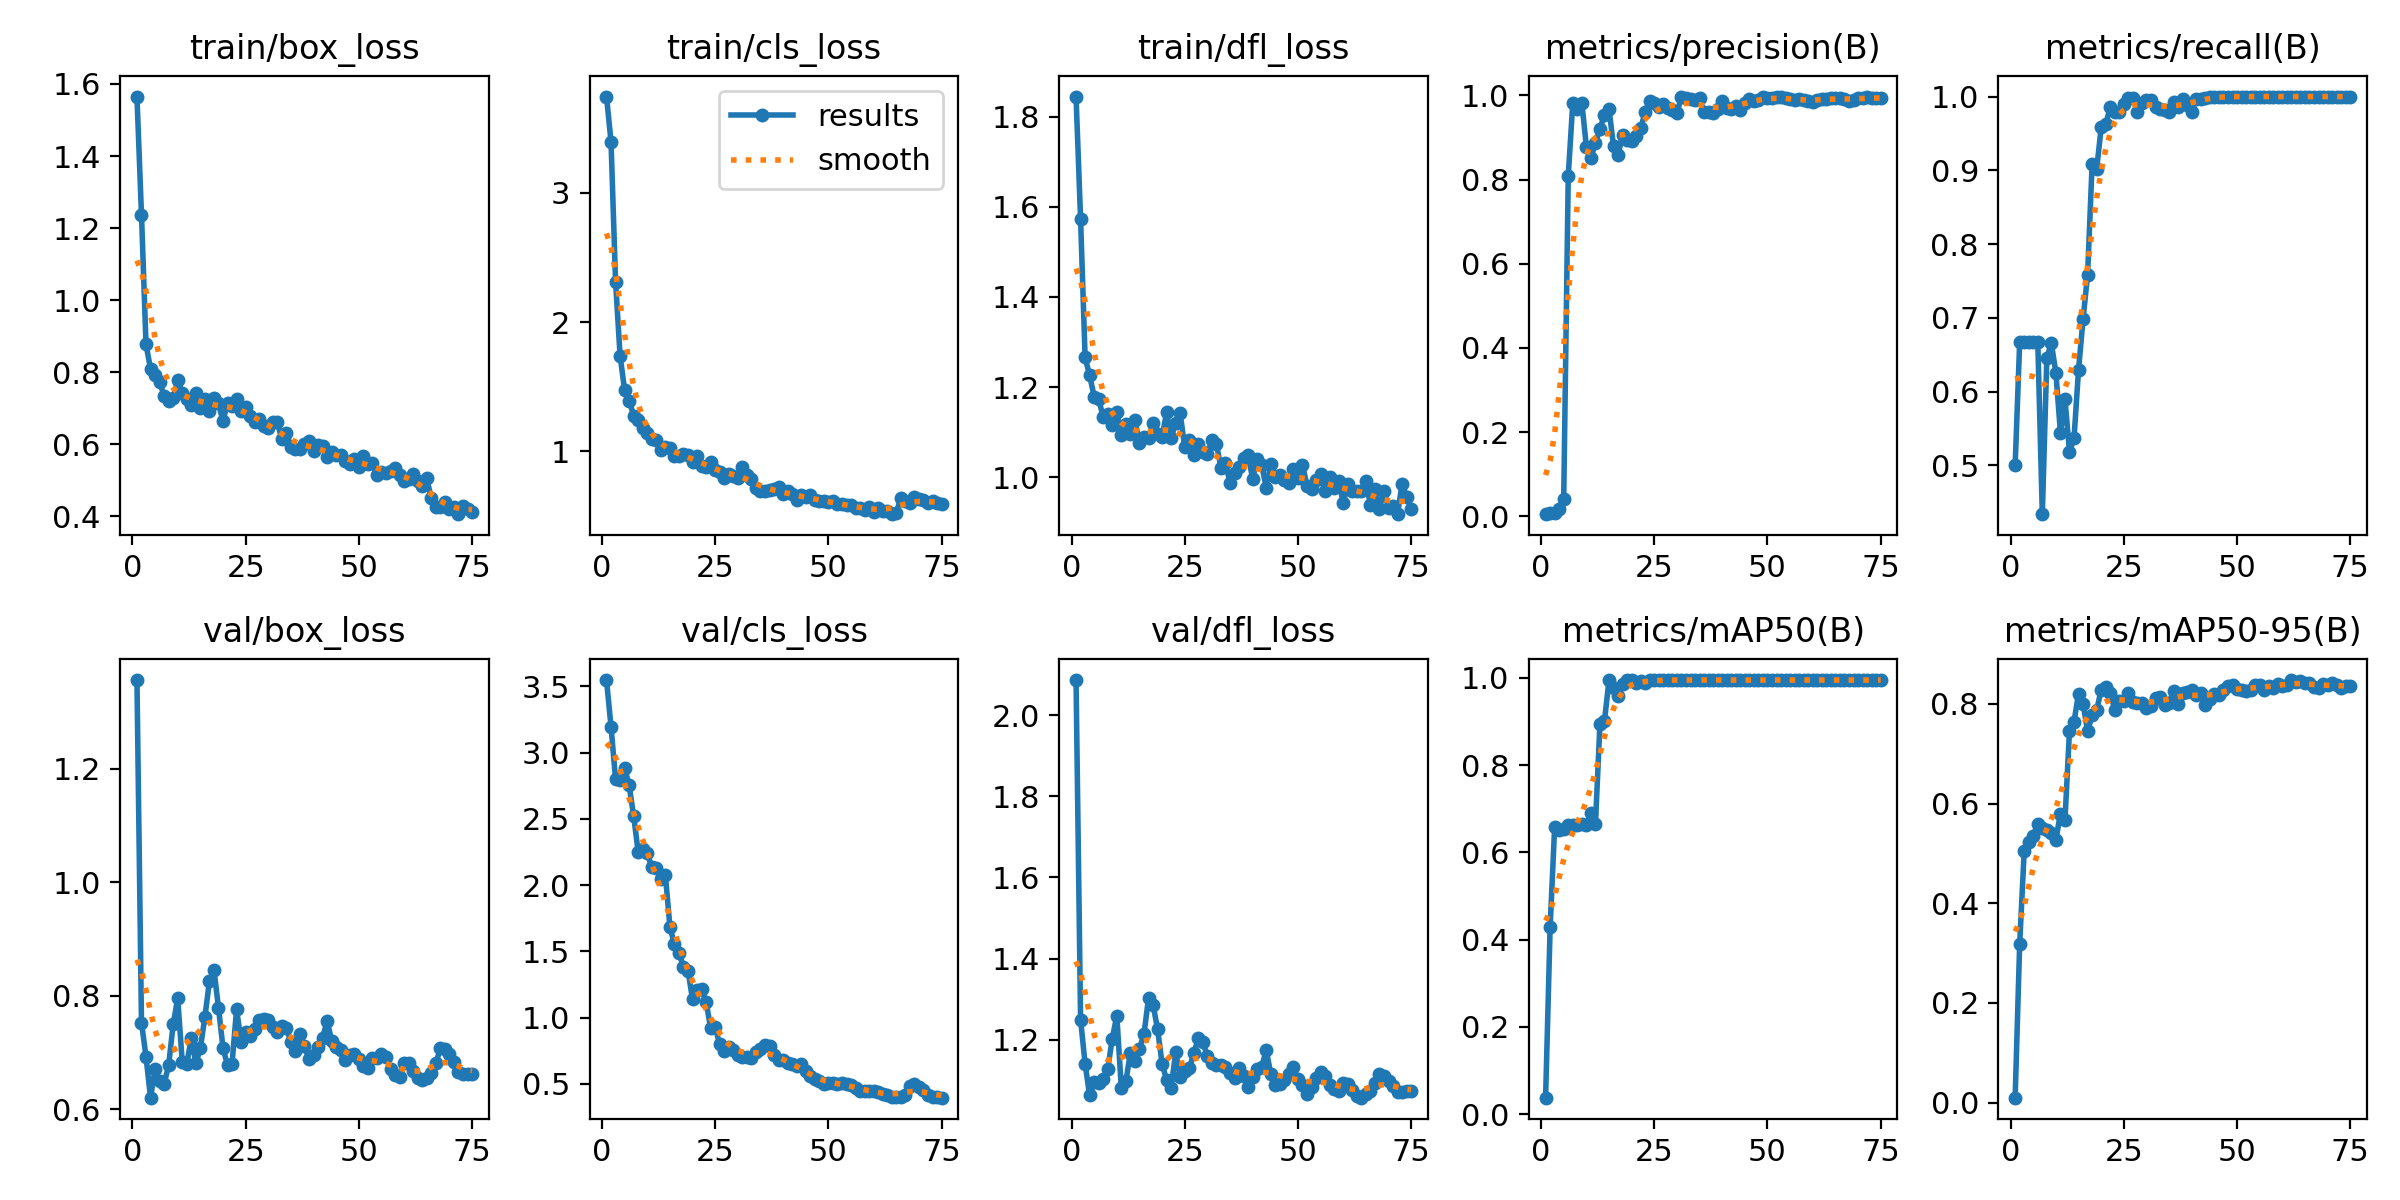

In [10]:
from IPython.display import Image, display
display(Image(filename='runs/detect/train/results.png'))

In [11]:
results = model.predict(source='/content/drive/MyDrive/AI_ML_Project/test/1709617694248.jpg', save=True, imgsz=640)


image 1/1 /content/drive/MyDrive/AI_ML_Project/test/1709617694248.jpg: 640x640 1 tongue, 1 colorcard, 1 blue, 11.3ms
Speed: 6.6ms preprocess, 11.3ms inference, 2.8ms postprocess per image at shape (1, 3, 640, 640)
Results saved to runs/detect/train3


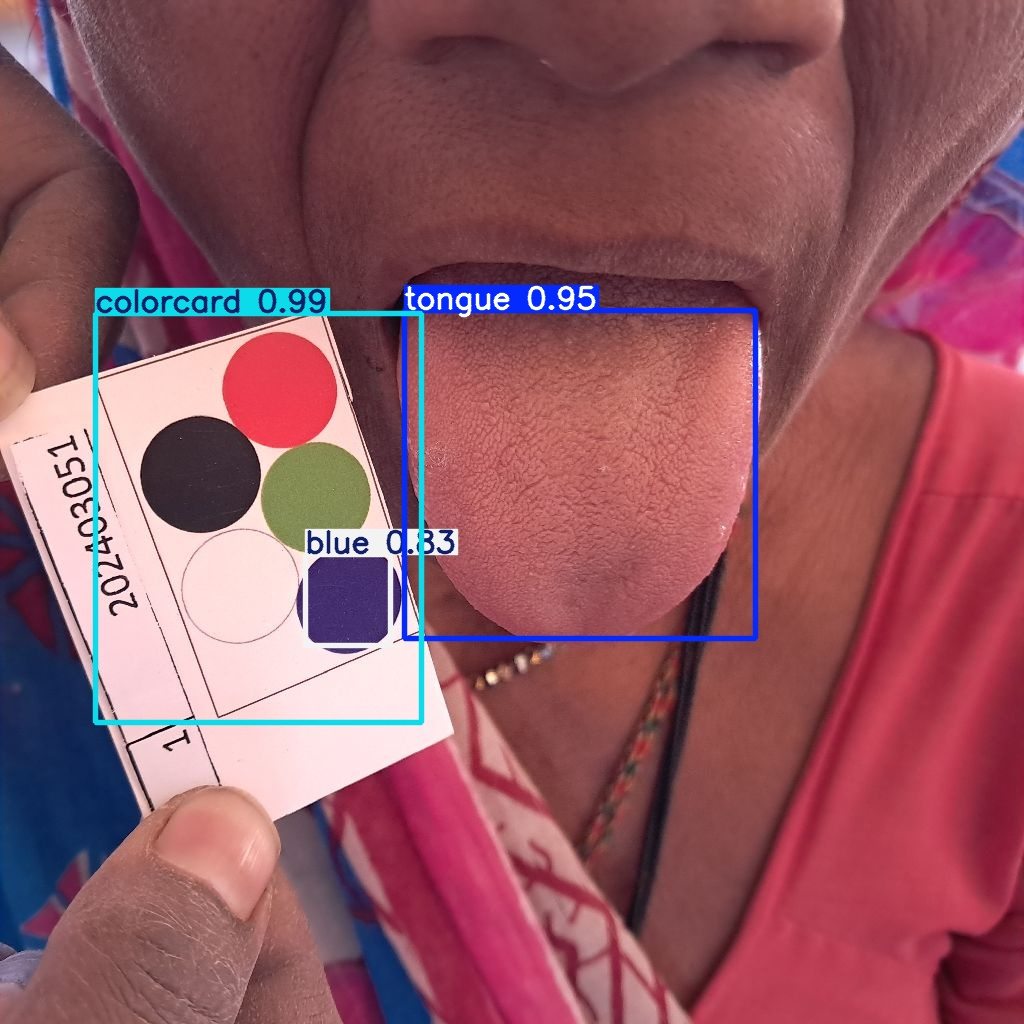

In [12]:
from IPython.display import Image
display(Image(filename='runs/detect/train3/1709617694248.jpg'))

In [13]:
from IPython.display import Image
display(Image(filename='runs/detect/train4/1709617844626.jpg'))

FileNotFoundError: [Errno 2] No such file or directory: 'runs/detect/train4/1709617844626.jpg'

In [14]:
from google.colab import files
model_path = 'runs/detect/train/weights/best.pt'  # Adjust to your model's path (this saves the model)
files.download(model_path)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>